---
<h1 align="center"><strong>Cálculo de dependencia cruzada para policy brief R.I. Elcano</strong></h1>
<h4 align="center"><strong>Manuel Alejandro Hidalgo, Jorge Díaz Lanchas y Miguel Otero</strong></h4>
<h4 align="center"><strong>Fundación Real Instituto Elcano</strong></h4>

---

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gzip
import shutil
import os
import tempfile
# Al principio del script, después de los imports
import os
from pathlib import Path

In [7]:
#Valores totales industria-país
df_totales = pd.read_csv('../../data/processed/Dependencias consolidadas/totales_comercio_por_pais_industria.csv', sep=";") 
# Ruta del archivo comprimido
ruta_archivo_gz = '../../data/processed/Dependencias consolidadas/dependencias.gz'

# ID industrias y nombre 
df_industry = pd.read_csv('../../data/processed/Dependencias consolidadas/industrias_id_nombre.csv', sep=";")
#Definición macrosectores


condiciones = [
    (df_industry['industry_id'] >= 1) & (df_industry['industry_id'] <= 26),
    (df_industry['industry_id'] >= 27) & (df_industry['industry_id'] <= 33),
    (df_industry['industry_id'] >= 34) & (df_industry['industry_id'] <= 153),
    (df_industry['industry_id'] >= 154) & (df_industry['industry_id'] <= 170)
]

opciones = ['agricultura', 'minería y energía', 'manufacturas', 'servicios']

df_industry['sectores'] = np.select(condiciones, opciones, default='otro')
df_industry = df_industry.rename(columns={'industry_descr': 'industry'})


# Crear un directorio temporal para descomprimir
directorio_temp = tempfile.mkdtemp()
print(f"Directorio temporal creado en: {directorio_temp}")

try:
    # Ruta del archivo descomprimido en el directorio temporal
    ruta_archivo_csv = os.path.join(directorio_temp, "dependencias.csv")
    
    # Descomprimir el archivo
    print("Descomprimiendo archivo...")
    with gzip.open(ruta_archivo_gz, 'rb') as f_in:
        with open(ruta_archivo_csv, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print(f"Archivo descomprimido en: {ruta_archivo_csv}")
    
    # Leer el archivo CSV
    print("Leyendo el archivo CSV...")
    df = pd.read_csv(ruta_archivo_csv, sep=';')
    
    # Definir las columnas a revisar
    columnas_check = ['dependency_value', 'direct_dependency', 'indirect_dependency', 'trade_value']
    
    # Eliminar las filas donde todas las columnas especificadas son 0
    print("Limpiando el dataframe...")
    df_limpio = df[~(df[columnas_check] == 0).all(axis=1)]

    # Suponiendo que tienes df1 y df2
    df_limpio = pd.merge(
        left=df_limpio,              # DataFrame principal (prevalece)
        right=df_industry,             # DataFrame secundario
        how='left',            # Para mantener todas las filas del df1
        on='industry'     # Columna(s) para unir
    )
        
    # Imprimir información sobre el proceso
    print(f"Registros originales: {len(df)}")
    print(f"Registros después de eliminar filas con ceros: {len(df_limpio)}")
    print(f"Se eliminaron {len(df) - len(df_limpio)} registros")
    
    # Guardar una copia del dataframe limpio en memoria
    print("Guardando dataframe limpio en memoria como df_limpio")
    # Esta variable estará disponible para uso posterior

finally:
    # Limpiar eliminando archivos temporales
    print(f"Eliminando archivos temporales de: {directorio_temp}")
    shutil.rmtree(directorio_temp)
    print("Limpieza completada. Espacio en disco liberado.")

Directorio temporal creado en: C:\Users\Usuario\AppData\Local\Temp\tmpcsf9igb5
Descomprimiendo archivo...
Archivo descomprimido en: C:\Users\Usuario\AppData\Local\Temp\tmpcsf9igb5\dependencias.csv
Leyendo el archivo CSV...
Limpiando el dataframe...
Registros originales: 7278726
Registros después de eliminar filas con ceros: 1272249
Se eliminaron 6006477 registros
Guardando dataframe limpio en memoria como df_limpio
Eliminando archivos temporales de: C:\Users\Usuario\AppData\Local\Temp\tmpcsf9igb5
Limpieza completada. Espacio en disco liberado.


In [8]:
df = df_limpio.copy()


# Configuración de estilo general
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


# Países de interés
countries = {
    'CAN': 'Canadá',
    'MEX': 'México',
    'DEU': 'Alemania',
    'FRA': 'Francia',
    'ITA': 'Italia',
    'ESP': 'España',
    'GBR': 'Reino Unido'
}

# Filtrar datos para USA como proveedor y los países de interés
usa_deps = df[
    (df['supplier_country'] == 'USA') & 
    (df['dependent_country'].isin(countries.keys()))
].copy()

# Merge entre el valor total importado y la depedencia de EEUU
df_totales = df_totales.rename(columns={
    'industria': 'industry',
    'pais': 'dependent_country'
})

# Ahora hacemos el merge, manteniendo todos los datos del primer DataFrame
# y añadiendo la columna valor_importado del segundo
usa_deps = pd.merge(
    usa_deps,  # El primer DataFrame (que prevalece)
    df_totales[['industry', 'dependent_country', 'valor_importado']],  # Solo las columnas que necesitamos
    on=['industry', 'dependent_country'],  # Columnas para unir
    how='left'  # Mantener todas las filas del DataFrame izquierdo (primero)
)

Sectores únicos encontrados: ['manufacturas' 'agricultura' 'servicios' 'minería y energía']
Procesando país: Canadá
Procesando país: México
Procesando país: Alemania
Procesando país: Francia
Procesando país: Italia
Procesando país: España
Procesando país: Reino Unido


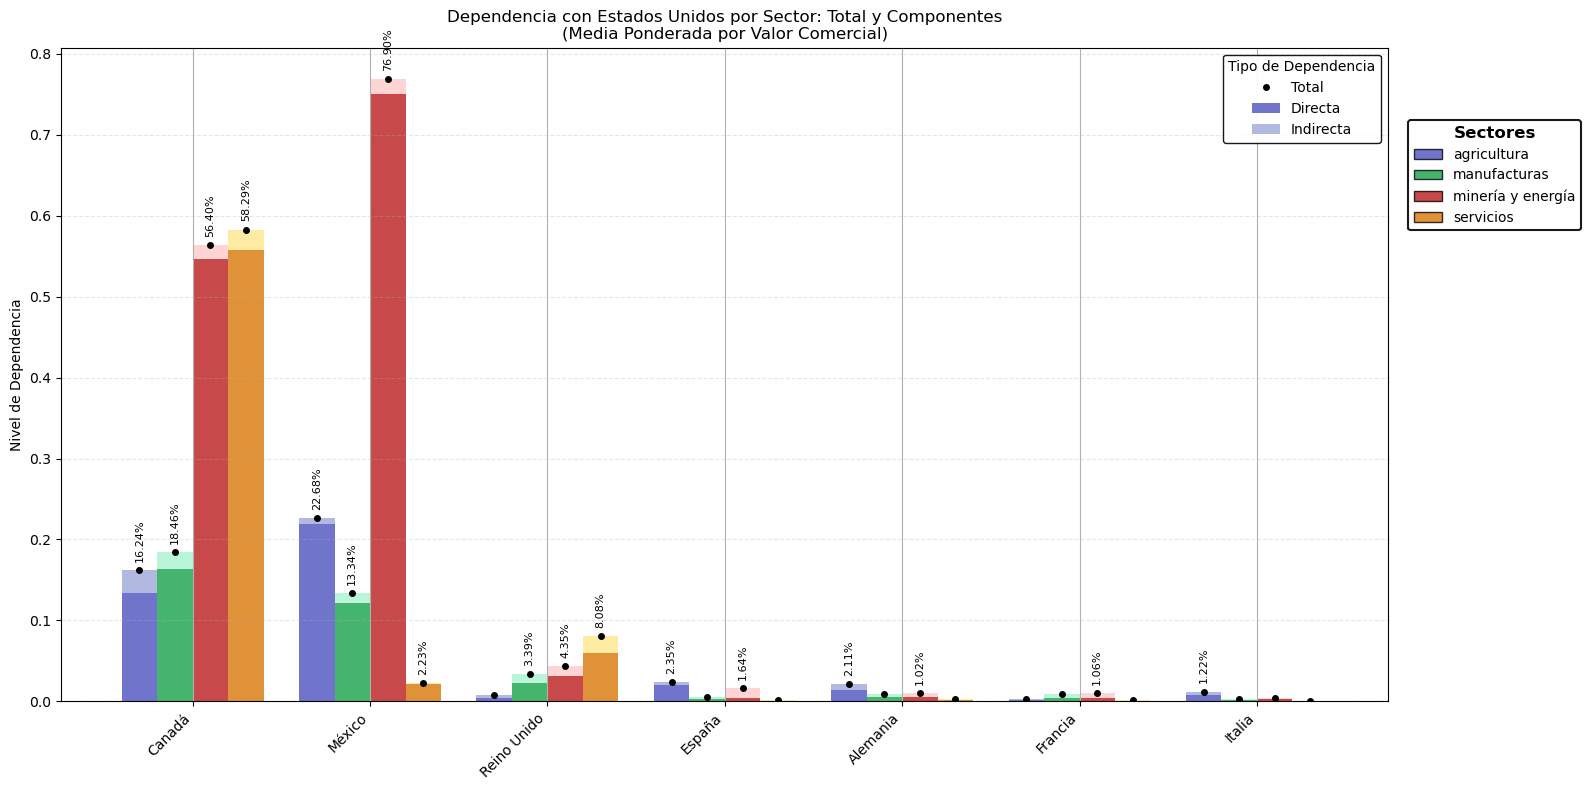

In [9]:
usa_deps['dependent_country'] = usa_deps['dependent_country'].map(countries)

# Obtener lista única de sectores
sectores_unicos = usa_deps['sectores'].unique()
print(f"Sectores únicos encontrados: {sectores_unicos}")

# Inicializar lista para almacenar resultados
deps_by_country_sector = []

# Procesar cada país y sector
for country in countries.values():
    print(f"Procesando país: {country}")
    country_data = usa_deps[usa_deps['dependent_country'] == country]
    
    # Para cada sector dentro de cada país
    for sector in sectores_unicos:
        sector_data = country_data[country_data['sectores'] == sector]
        
        # Si no hay datos para este sector en este país, continuamos
        if sector_data.empty:
            continue
            
        # El total importado es específico para este país y sector
        total_importado_sector = sector_data['valor_importado'].sum()
        
        # Si el total importado es cero, continuamos al siguiente sector
        if total_importado_sector == 0:
            continue
            
        # Calcular pesos para este sector específico
        sector_data = sector_data.copy()  # Crear copia para evitar SettingWithCopyWarning
        sector_data['peso'] = sector_data['trade_value'] / total_importado_sector
        
        # Calcular dependencias ponderadas por sector
        sector_data['dependency_value_pond'] = sector_data['dependency_value'] * sector_data['peso']
        sector_data['direct_dependency_pond'] = sector_data['direct_dependency'] * sector_data['peso']
        sector_data['indirect_dependency_pond'] = sector_data['indirect_dependency'] * sector_data['peso']
        
        # Calcular medias ponderadas para este sector específico
        weighted_total = np.sum(sector_data['dependency_value_pond'])
        weighted_direct = np.sum(sector_data['direct_dependency_pond'])
        weighted_indirect = np.sum(sector_data['indirect_dependency_pond'])
        
        # Guardar resultados
        deps_by_country_sector.append({
            'dependent_country': country,
            'sector': sector,
            'dependency_value': weighted_total,
            'direct_dependency': weighted_direct,
            'indirect_dependency': weighted_indirect
        })

# Convertir a DataFrame
deps_by_country_sector = pd.DataFrame(deps_by_country_sector)

# Ordenar países por su dependencia total promedio
country_avg_dependency = deps_by_country_sector.groupby('dependent_country')['dependency_value'].mean().reset_index()
country_avg_dependency = country_avg_dependency.sort_values('dependency_value', ascending=False)
ordered_countries = country_avg_dependency['dependent_country'].tolist()

# Preparar datos para graficar
deps_by_country_sector['country_order'] = deps_by_country_sector['dependent_country'].apply(
    lambda x: ordered_countries.index(x) if x in ordered_countries else 999
)
deps_by_country_sector = deps_by_country_sector.sort_values(['country_order', 'sector'])

# CÓDIGO DEL GRÁFICO
# Crear figura
fig, ax = plt.subplots(figsize=(16, 8))

# Configurar dimensiones
num_countries = len(ordered_countries)
num_sectors = len(sectores_unicos)
group_width = 0.8  # Ancho total disponible para cada grupo de país
bar_width = group_width / num_sectors  # Ancho de cada barra individual

# Definir colores para los sectores y crear un diccionario de mapeo
sorted_sectors = sorted(sectores_unicos)
colors = ['#4C51BF', '#16A34A', '#B91C1C', '#D97706']
light_colors = ['#9FA8DA', '#A7F3D0', '#FECACA', '#FDE68A']

# Crear diccionarios para mapear sectores a colores
sector_to_color = {sector: colors[i % len(colors)] for i, sector in enumerate(sorted_sectors)}
sector_to_light_color = {sector: light_colors[i % len(light_colors)] for i, sector in enumerate(sorted_sectors)}

# Crear barras para cada país y sector
for i, country in enumerate(ordered_countries):
    country_data = deps_by_country_sector[deps_by_country_sector['dependent_country'] == country]
    
    for j, sector in enumerate(sorted_sectors):
        sector_data = country_data[country_data['sector'] == sector]
        
        if sector_data.empty:
            continue
            
        # Posición x para esta barra específica
        x_pos = i + (j * bar_width) - (group_width / 2) + (bar_width / 2)
        
        # Crear barras apiladas para este sector y país
        direct_val = sector_data['direct_dependency'].values[0] if not sector_data.empty else 0
        indirect_val = sector_data['indirect_dependency'].values[0] if not sector_data.empty else 0
        total_val = sector_data['dependency_value'].values[0] if not sector_data.empty else 0
        
        # Usar los colores del diccionario
        p1 = ax.bar(x_pos, direct_val, bar_width,
                  label=f'Directa' if i == 0 and j == 0 else "",
                  color=sector_to_color[sector], alpha=0.8)
        
        # Barras de dependencia indirecta (apiladas)
        p2 = ax.bar(x_pos, indirect_val, bar_width,
                  bottom=direct_val,
                  label=f'Indirecta' if i == 0 and j == 0 else "",
                  color=sector_to_light_color[sector], alpha=0.8)
        
        # Añadir marcador para dependencia total
        ax.plot(x_pos, total_val, 'ko', markersize=4,
              label=f'Total' if i == 0 and j == 0 else "")
        
        # Añadir valor encima de la barra
        if total_val > 0.01:  # Solo mostrar valores significativos
            ax.text(x_pos, total_val + 0.01, f'{total_val:.2%}', 
                  ha='center', va='bottom', fontsize=8, rotation=90)

# Configurar ejes y leyendas
ax.set_xticks(np.arange(len(ordered_countries)))
ax.set_xticklabels(ordered_countries, rotation=45, ha='right')
ax.set_ylabel('Nivel de Dependencia')
ax.set_title('Dependencia con Estados Unidos por Sector: Total y Componentes\n(Media Ponderada por Valor Comercial)')

# Crear leyenda para los tipos de dependencia (primera leyenda)
handles, labels = ax.get_legend_handles_labels()
first_legend = ax.legend(handles[:3], labels[:3], loc='upper right', 
                        title="Tipo de Dependencia", frameon=True, 
                        framealpha=0.9, edgecolor='black')

ax.add_artist(first_legend)  # Mantener la primera leyenda

# Crear leyenda separada para los sectores (segunda leyenda)
# Esta vez con rectángulos más grandes y etiquetas más visibles
sector_handles = []

for sector in sorted_sectors:
    # Crear un rectángulo más grande para cada sector
    sector_handle = plt.Rectangle((0, 0), 1, 1, fc=sector_to_color[sector], alpha=0.8, 
                                ec='black', linewidth=1)
    sector_handles.append(sector_handle)

# Colocar la leyenda de sectores en un lugar más visible
second_legend = ax.legend(sector_handles, sorted_sectors, 
                        loc='upper left', bbox_to_anchor=(1.01, 0.9),
                        title="Sectores", frameon=True, framealpha=0.9,
                        edgecolor='black', title_fontsize=12, fontsize=10)

# Mejorar la apariencia de la leyenda de sectores
second_legend.get_frame().set_linewidth(1.5)
plt.setp(second_legend.get_title(), fontweight='bold')

# Añadir una etiqueta debajo de cada país que indique el sector
# mediante un pequeño cuadrado de color en la parte inferior del gráfico
for i, country in enumerate(ordered_countries):
    for j, sector in enumerate(sorted_sectors):
        # Posición x para la etiqueta
        x_pos = i + (j * bar_width) - (group_width / 2) + (bar_width / 2)
        
        # Crear un pequeño texto o indicador de color en la parte inferior
        # (Opcional) Descomentar si quieres etiquetas debajo de cada barra
        # ax.text(x_pos, -0.05, sector[0], ha='center', va='top', fontsize=7, 
        #         color=sector_to_color[sector], fontweight='bold', 
        #         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))

# Añadir grid para facilitar lectura
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Ajustar diseño para evitar recortes
plt.tight_layout()



current_dir = Path.cwd()
image_dir = current_dir.parent.parent / 'docs' / 'policy brief USA' / 'images'
image_dir.mkdir(parents=True, exist_ok=True)

plt.savefig(image_dir / 'usa_weighted_dependency_components.png', dpi=300, bbox_inches='tight')
    
# Mostrar gráfico
plt.show()


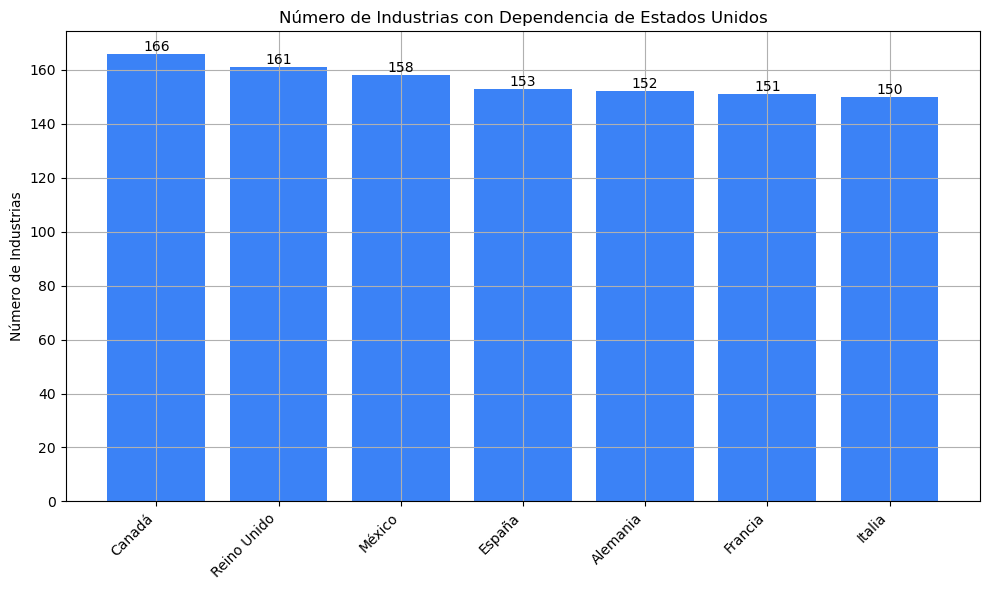

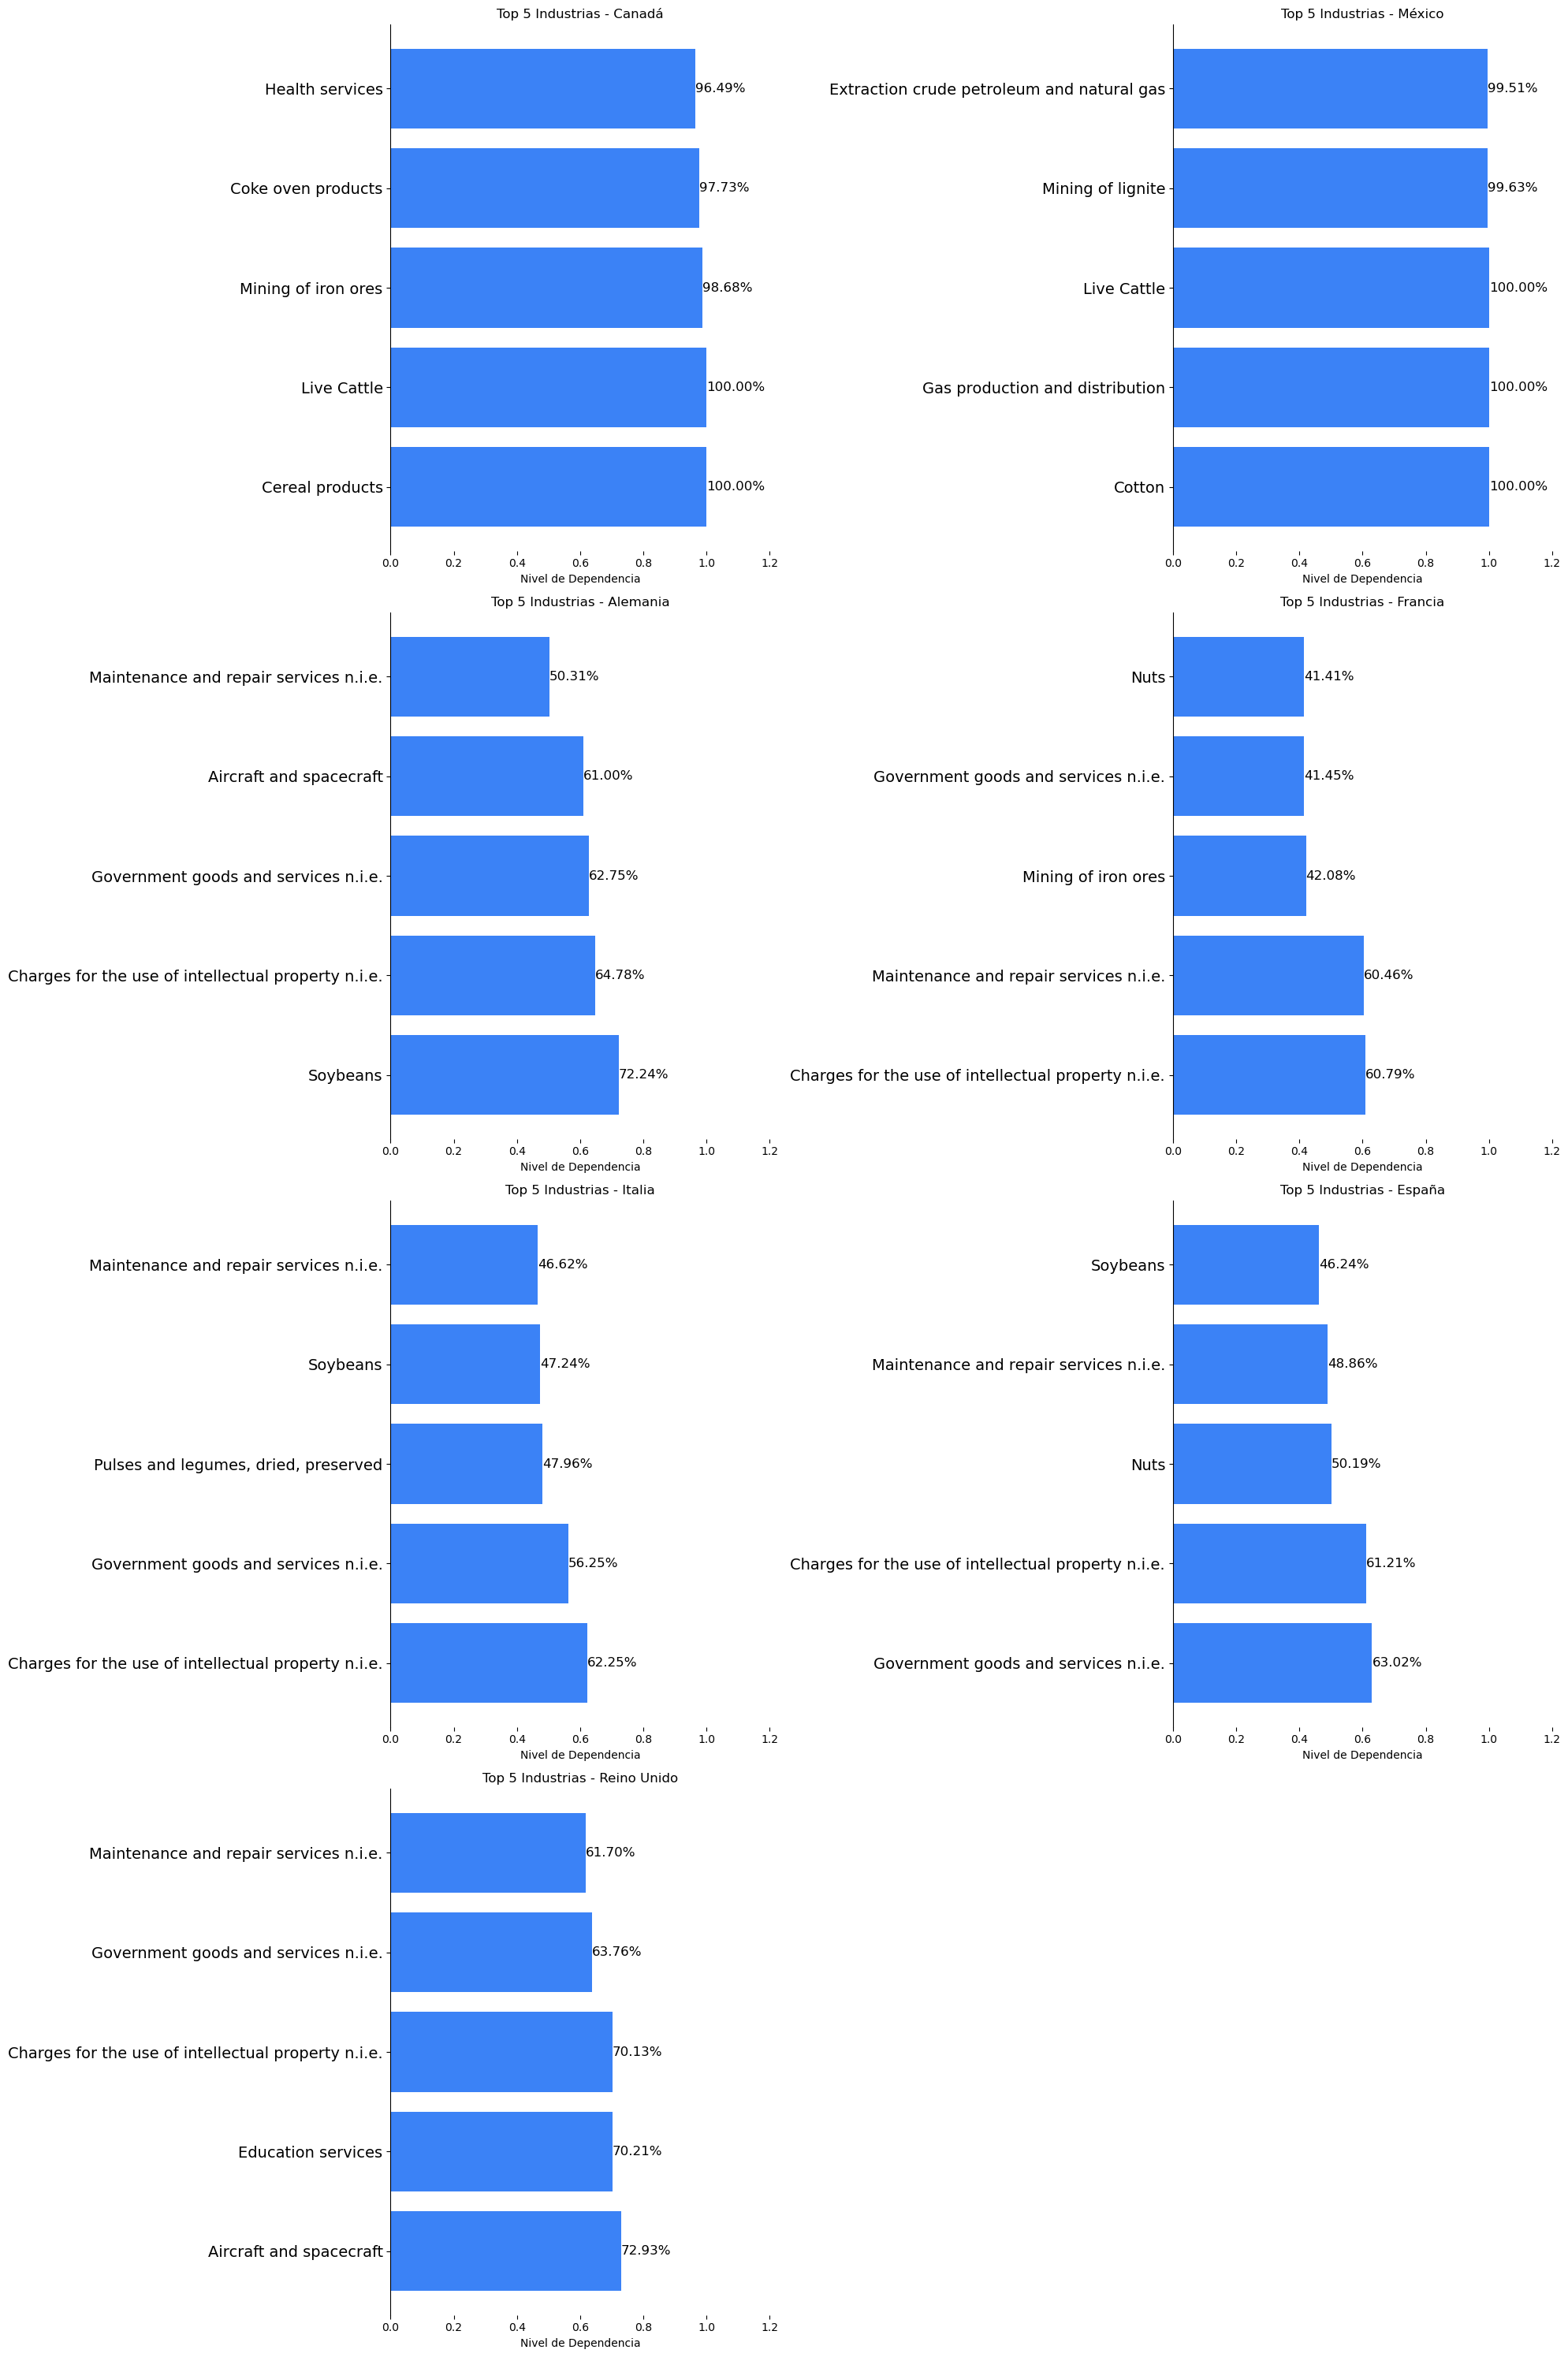

Imágenes guardadas en: c:\Users\Usuario\Documents\Github\Seguridad Economica\src\docs\policy brief USA\images


In [10]:


# Figura 2: Número de Industrias Dependientes
def plot_industries_count():
    industry_counts = usa_deps.groupby('dependent_country').size().reset_index()
    industry_counts.columns = ['País', 'Número de Industrias']
    industry_counts = industry_counts.sort_values('Número de Industrias', ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(industry_counts['País'], industry_counts['Número de Industrias'], 
                 color='#3B82F6')
    
    # Añadir etiquetas de valor sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Número de Industrias con Dependencia de Estados Unidos')
    plt.ylabel('Número de Industrias')
    plt.tight_layout()
    
    return fig

# Figura 3: Top Industrias por País (considerando valor comercial)
def plot_top_industries():
    plt.style.use('default')
    
    # Cambiar a 4x2 para acomodar los 7 países
    fig, axes = plt.subplots(4, 2, figsize=(20, 30))  # Aumentar altura
    plt.subplots_adjust(right=0.85)
    axes = axes.ravel()
    
    selected_countries = list(countries.values())  # Usar todos los países
    
    for idx, country in enumerate(selected_countries):
        country_data = usa_deps[usa_deps['dependent_country'] == country].copy()
        
        top_industries = country_data.nlargest(5, 'dependency_value')
        
        bars = axes[idx].barh(top_industries['industry'], 
                            top_industries['dependency_value'],
                            color='#3B82F6')
        
        # Eliminar grid y ajustar spines
        axes[idx].grid(False)
        for spine in axes[idx].spines.values():
            spine.set_visible(False)
        axes[idx].spines['left'].set_visible(True)
        
        # Ajustar etiquetas
        for bar, trade_val in zip(bars, top_industries['trade_value']):
            width = bar.get_width()
            axes[idx].text(width, bar.get_y() + bar.get_height()/2.,
                          f'{width:.2%}',
                          ha='left', va='center', fontsize=12)
        
        # Aumentar el tamaño de fuente de las etiquetas del eje Y
        axes[idx].tick_params(axis='y', labelsize=14)

        axes[idx].set_title(f'Top 5 Industrias - {country}')
        axes[idx].set_xlabel('Nivel de Dependencia')
        axes[idx].set_xlim(0, 1.2)  # Dar espacio para las etiquetas
    
    # Eliminar el último subplot que queda vacío
    fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    return fig

# Generar estadísticas descriptivas
def print_weighted_statistics():
    print("\nEstadísticas de dependencia por país (ponderadas por valor comercial):")
    
    stats = []
    for country in countries.values():
        country_data = usa_deps[usa_deps['dependent_country'] == country]
        
        weighted_stats = {
            'País': country,
            'Media Ponderada Total': np.average(
                country_data['dependency_value'],
                weights=country_data['trade_value']
            ),
            'Media Ponderada Directa': np.average(
                country_data['direct_dependency'],
                weights=country_data['trade_value']
            ),
            'Media Ponderada Indirecta': np.average(
                country_data['indirect_dependency'],
                weights=country_data['trade_value']
            ),
            'Valor Comercial Total (M$)': country_data['trade_value'].sum()
        }
        stats.append(weighted_stats)
    
    stats_df = pd.DataFrame(stats)
    print(stats_df.round(3))
    
    # Top 3 industrias más dependientes por país (considerando valor comercial)
    for country in countries.values():
        print(f"\nTop 3 industrias más dependientes - {country}:")
        country_data = usa_deps[usa_deps['dependent_country'] == country]
        top3 = country_data.nlargest(3, 'dependency_value')[
            ['industry', 'dependency_value', 'trade_value']
        ].round(3)
        print(top3)

# Guardar gráficos

# Al final del script, reemplazar la parte de guardar las figuras con:
try:
    # Configurar directorio de salida
    
    fig2 = plot_industries_count()
    fig2.savefig(image_dir / 'usa_industries_count.png', dpi=300, bbox_inches='tight')
    
    fig3 = plot_top_industries()
    fig3.savefig(image_dir / 'usa_top_industries_weighted.png', dpi=300, bbox_inches='tight')
    
    print(f"Imágenes guardadas en: {image_dir}")
    
except Exception as e:
    print(f"Error al guardar las imágenes: {str(e)}")
finally:
    plt.close('all')

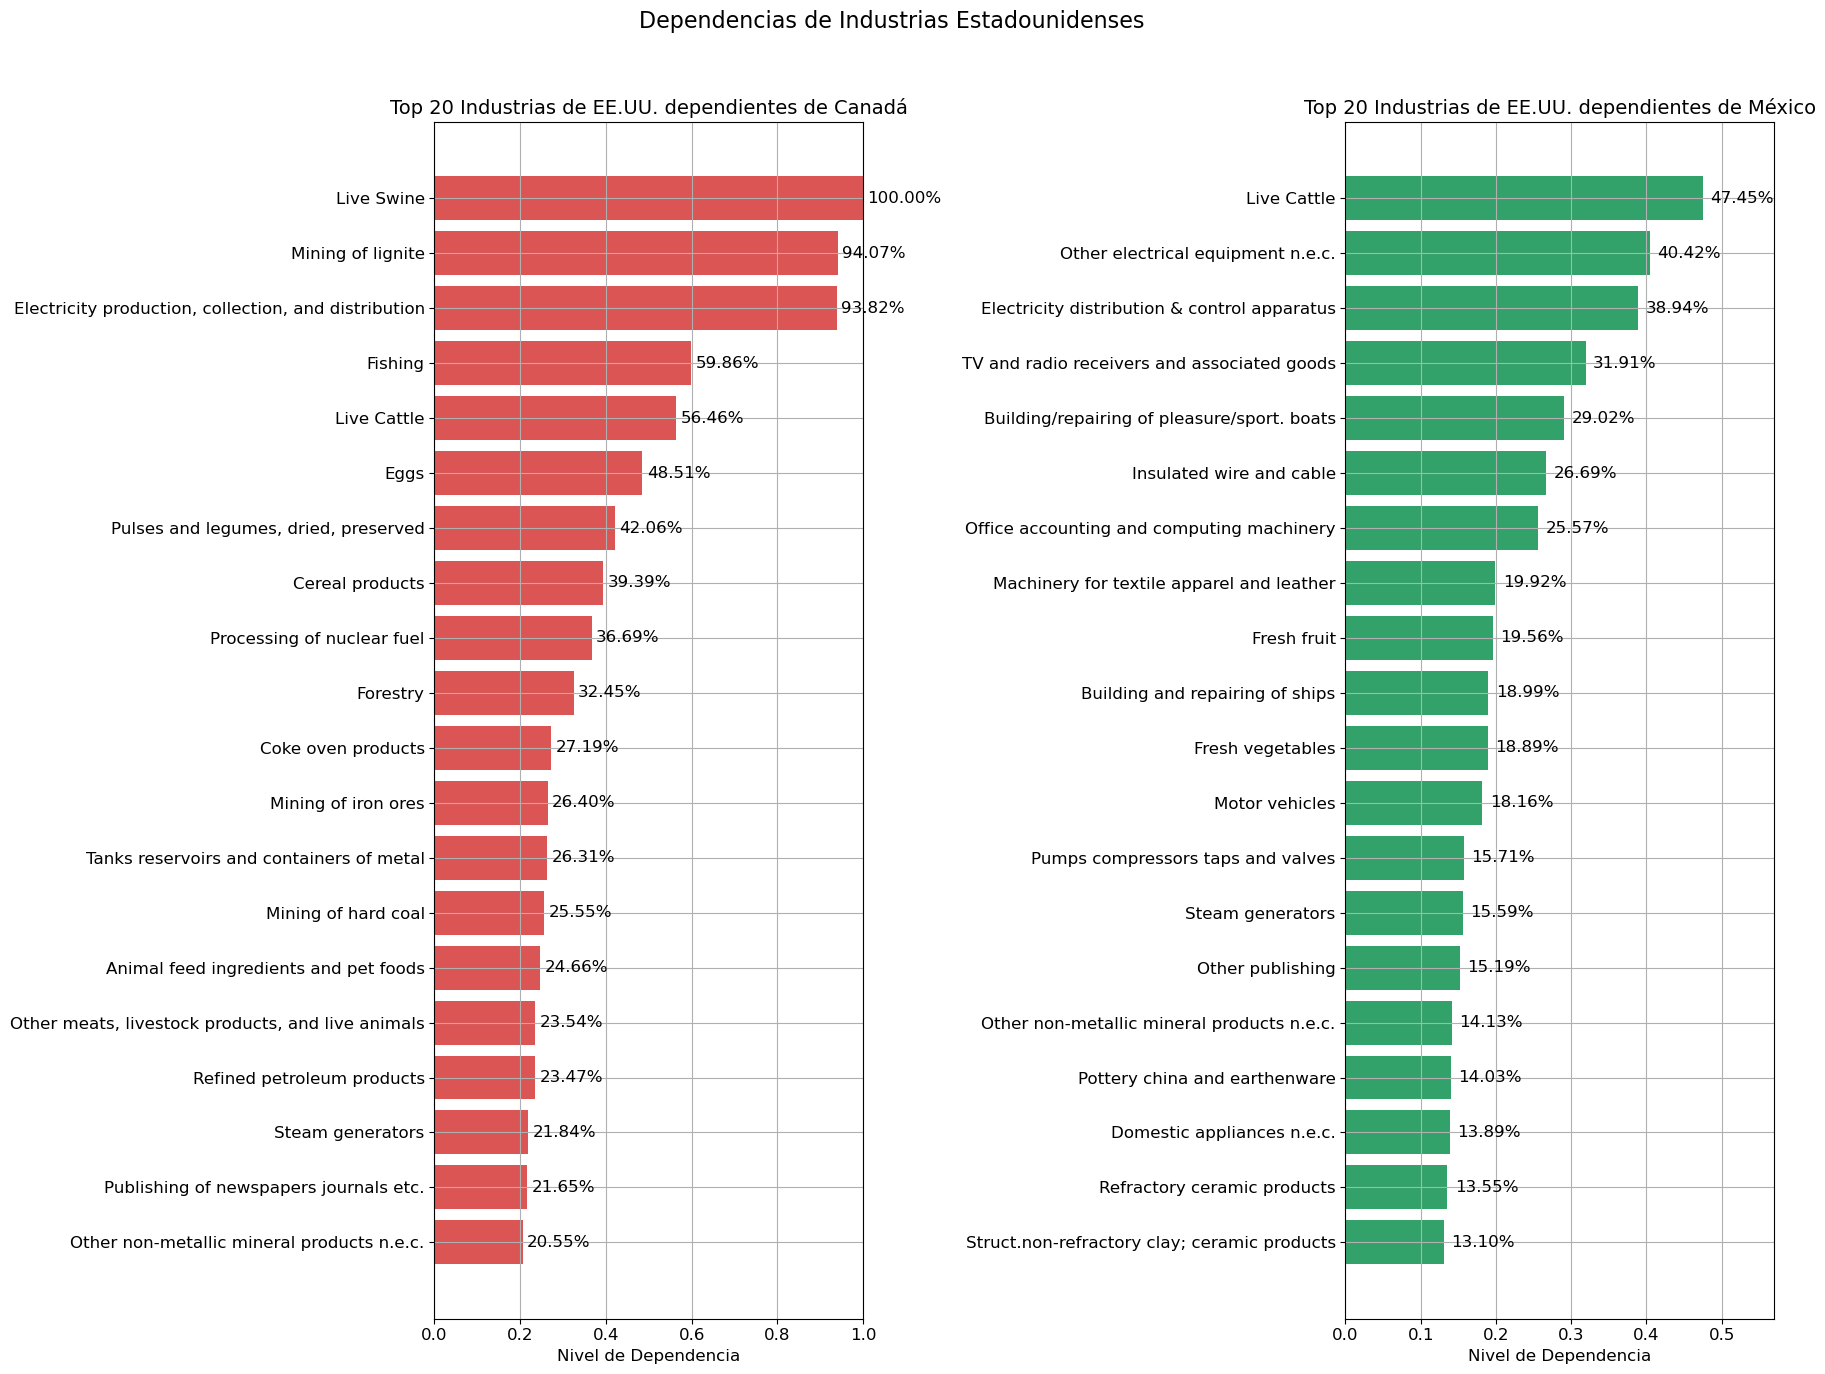

In [11]:
# Configuración de estilo general
plt.rcParams['figure.figsize'] = [18, 14]  # Más ancho y alto para adaptarse mejor a una página de Word
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12  # Aumentar tamaño de fuente para mejor legibilidad


# Usamos df_limpio como base (asumiendo que ya está cargado)
df = df_limpio.copy()

# Función para obtener las 10 industrias de EE.UU. más dependientes de un país proveedor
def get_top_industries_dependent_on(supplier_country, n=20):
    """
    Obtiene las n industrias de EE.UU. más dependientes de un país proveedor.
    
    Parameters:
    supplier_country (str): Código ISO3 del país proveedor
    n (int): Número de industrias a retornar
    
    Returns:
    pandas.DataFrame: Top n industrias ordenadas por nivel de dependencia
    """
    # Filtrar datos donde EE.UU. es el país dependiente y el proveedor es el país especificado
    deps = df[
        (df['dependent_country'] == 'USA') & 
        (df['supplier_country'] == supplier_country)
    ].copy()
    
    if deps.empty:
        print(f"No hay datos para {supplier_country} como proveedor de EE.UU.")
        return pd.DataFrame()
    
    # Agrupar por industria para calcular la dependencia ponderada
    industry_deps = []
    
    for industry in deps['industry'].unique():
        industry_data = deps[deps['industry'] == industry]
        
        # Verificar que hay valores de trade_value mayores que cero
        if industry_data['trade_value'].sum() > 0:
            try:
                # Calcular media ponderada de dependencia total
                weighted_dependency = np.average(
                    industry_data['dependency_value'],
                    weights=industry_data['trade_value']
                )
                
                # Sumar el valor comercial total
                total_trade_value = industry_data['trade_value'].sum()
                
                industry_deps.append({
                    'industry': industry,
                    'dependency_value': weighted_dependency,
                    'trade_value': total_trade_value
                })
            except ZeroDivisionError:
                # Manejar el caso donde los pesos suman cero
                continue
    
    if not industry_deps:
        print(f"No se encontraron industrias válidas para {supplier_country}")
        return pd.DataFrame()
    
    # Convertir a DataFrame y ordenar por valor de dependencia
    industry_deps_df = pd.DataFrame(industry_deps)
    top_industries = industry_deps_df.sort_values('dependency_value', ascending=False).head(n)
    
    return top_industries

# Diccionario para nombres de países
country_names = {
    'CAN': 'Canadá',
    'MEX': 'México'
}

# Colores para cada país
colors = {
    'CAN': '#D22B2B',  # Rojo
    'MEX': '#008B45'   # Verde
}
# Crear la figura con dos subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 14))  # 1 fila, 2 columnas con mayor altura


# 1. Top 10 industrias de EE.UU. dependientes de Canadá
try:
    canada_deps = get_top_industries_dependent_on('CAN')
    
    if not canada_deps.empty:
        # Ordenar ascendente para visualización
        canada_deps = canada_deps.sort_values('dependency_value')
        
        # Crear barras horizontales
        bars1 = ax1.barh(
            canada_deps['industry'], 
            canada_deps['dependency_value'],
            color=colors['CAN'], 
            alpha=0.8
        )
        
        # Añadir etiquetas de valores
        for bar in bars1:
            width = bar.get_width()
            ax1.text(
                width + 0.01, 
                bar.get_y() + bar.get_height()/2,
                f'{width:.2%}', 
                va='center'
            )
        
        # Configurar título y etiquetas
        ax1.set_title(
            f'Top 20 Industrias de EE.UU. dependientes de {country_names["CAN"]}', 
            fontsize=14
        )
        ax1.set_xlabel('Nivel de Dependencia')
        ax1.set_xlim(0, min(1, canada_deps['dependency_value'].max() * 1.2))
    else:
        ax1.text(0.5, 0.5, 'No hay datos disponibles para Canadá', 
                ha='center', va='center', fontsize=14)
except Exception as e:
    print(f"Error al procesar datos de Canadá: {str(e)}")
    ax1.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center')

# 2. Top 10 industrias de EE.UU. dependientes de México
try:
    mexico_deps = get_top_industries_dependent_on('MEX')
    
    if not mexico_deps.empty:
        # Ordenar ascendente para visualización
        mexico_deps = mexico_deps.sort_values('dependency_value')
        
        # Crear barras horizontales
        bars2 = ax2.barh(
            mexico_deps['industry'], 
            mexico_deps['dependency_value'],
            color=colors['MEX'], 
            alpha=0.8
        )
        
        # Añadir etiquetas de valores
        for bar in bars2:
            width = bar.get_width()
            ax2.text(
                width + 0.01, 
                bar.get_y() + bar.get_height()/2,
                f'{width:.2%}', 
                va='center'
            )
        
        # Configurar título y etiquetas
        ax2.set_title(
            f'Top 20 Industrias de EE.UU. dependientes de {country_names["MEX"]}', 
            fontsize=14
        )
        ax2.set_xlabel('Nivel de Dependencia')
        ax2.set_xlim(0, min(1, mexico_deps['dependency_value'].max() * 1.2))
    else:
        ax2.text(0.5, 0.5, 'No hay datos disponibles para México', 
                ha='center', va='center', fontsize=14)
except Exception as e:
    print(f"Error al procesar datos de México: {str(e)}")
    ax2.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center')

# Añadir un título general
fig.suptitle('Dependencias de Industrias Estadounidenses', fontsize=16, y=0.98)

# Ajustar el diseño
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Ajustar para dejar espacio al título general

# Mostrar la figura
plt.show()

# También se puede guardar la figura
fig.savefig(image_dir / 'usa_dependencias_can_mex.png', dpi=300, bbox_inches='tight')



In [12]:
# Configuración de estilo
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

# Usar el dataframe ya preparado
df = df_limpio.copy()

# Definir grupos de industrias estratégicas
strategic_sectors = {
    'Vehículo Eléctrico y Automóvil': [
        'Motor vehicles',
        'Parts/accessories for automobiles',
        'Automobile bodies trailers & semi-trailers',
        'Electric motors generators and transformers',
        'Electricity distribution & control apparatus',
        'Accumulators primary cells and batteries',
        'Other electrical equipment n.e.c.'
    ],
    
    'Semiconductores y Electrónica': [
        'Electronic valves tubes etc.',
        'Office accounting and computing machinery',
        'TV/radio transmitters; line comm. apparatus',
        'TV and radio receivers and associated goods',
        'Measuring/testing/navigating appliances etc.',
        'Telecommunications, computer, and information services',
        'Insulated wire and cable'
    ],
    
    'Defensa y Aeroespacial': [
        'Aircraft and spacecraft',
        'Building and repairing of ships',
        'Weapons and ammunition',
        'Optical instruments & photographic equipment',
        'Measuring/testing/navigating appliances etc.',
        'Other transport equipment n.e.c.'
    ]
}

# Países de interés
countries = {
    'CAN': 'Canadá',
    'MEX': 'México',
    'DEU': 'Alemania',
    'FRA': 'Francia',
    'ITA': 'Italia',
    'ESP': 'España',
    'GBR': 'Reino Unido'
}


def analyze_strategic_sector(df, sector_name, sector_industries):
    """
    Versión modificada de analyze_strategic_sector que separa el cálculo
    de dependencia directa e indirecta, permitiendo mostrar dependencia 
    indirecta incluso cuando el trade_value es cero.
    """
    # Filtrar datos para el sector
    sector_data = df[
        (df['supplier_country'] == 'USA') & 
        (df['dependent_country'].isin(countries.keys())) &
        (df['industry'].isin(sector_industries))
    ].copy()

    sector_data = pd.merge(
        sector_data,  # El primer DataFrame (que prevalece)
        df_totales[['industry', 'dependent_country', 'valor_importado']],  # Solo las columnas que necesitamos
        on=['industry', 'dependent_country'],  # Columnas para unir
        how='left'  # Mantener todas las filas del DataFrame izquierdo (primero)
    )
    
    # Primero, veamos qué industrias tenemos datos
    print(f"\nIndustrias encontradas en {sector_name}:")
    print(sector_data['industry'].unique())
    
    # Calcular dependencias ponderadas por país
    country_deps = []
    for country_code, country_name in countries.items():
        country_data = sector_data[sector_data['dependent_country'] == country_code]
        
        if len(country_data) > 0:
            # --- CAMBIO 1: Separar cálculos de dependencia directa e indirecta ---
            
            # Para dependencia directa, mantener filtro de trade_value > 0
            valid_trades = country_data['valor_importado'] > 0
            
            # Inicializar valores
            weighted_direct = 0
            weighted_indirect = 0
            weighted_total = 0
            total_trade = 0
            has_direct_data = False
            has_indirect_data = False

            total_importado_sector = country_data['valor_importado'].sum()
            country_data = country_data.copy()  # Crear copia para evitar SettingWithCopyWarning
            country_data['peso'] = country_data['trade_value'] / total_importado_sector if total_importado_sector > 0 else 0
            
            # Calcular dependencia directa si hay trade_value > 0
            if valid_trades.any():
                valid_data = country_data[valid_trades]
                
                weighted_direct = np.sum(
                    valid_data['direct_dependency']*valid_data['peso']
                )
                total_trade = valid_data['trade_value'].sum()
                has_direct_data = True
                
                # Calcular también la dependencia indirecta para estos mismos registros
                valid_indirect = np.sum(
                    valid_data['indirect_dependency']*valid_data['peso']
                )
                has_indirect_data = True
            
            # --- CAMBIO 2: Considerar dependencia indirecta incluso sin comercio directo ---
            # Verificar si hay dependencia indirecta en algún registro
            if not has_indirect_data and (country_data['indirect_dependency'] > 0).any():
                # Si no tenemos datos válidos para la dependencia indirecta pero existen valores,
                # calculamos un promedio simple (no ponderado)
                indirect_values = country_data[country_data['indirect_dependency'] > 0]['indirect_dependency']
                weighted_indirect = indirect_values.mean()
                has_indirect_data = True
                print(f"Nota: {country_name} tiene dependencia indirecta sin comercio directo válido")
            elif has_indirect_data:
                weighted_indirect = valid_indirect
            
            # --- CAMBIO 3: Calcular dependencia total como suma ---
            # La dependencia total es la suma de la directa e indirecta
            weighted_total = weighted_direct + weighted_indirect
            
            # Añadir información sobre industrias encontradas
            if has_direct_data:
                industries_found = valid_data['industry'].unique()
            else:
                industries_found = []
            
            missing_industries = set(sector_industries) - set(industries_found)
            
            country_deps.append({
                'País': country_name,
                'Dependencia Total': weighted_total,
                'Dependencia Directa': weighted_direct,
                'Dependencia Indirecta': weighted_indirect,
                'Valor Comercial': total_trade,
                'Tiene Dependencia Indirecta Sin Comercio': has_indirect_data and not has_direct_data,
                'Industrias Encontradas': len(industries_found),
                'Industrias Sin Datos': len(missing_industries)
            })
        else:
            print(f"Advertencia: No hay datos para {country_name}")
            country_deps.append({
                'País': country_name,
                'Dependencia Total': 0,
                'Dependencia Directa': 0,
                'Dependencia Indirecta': 0,
                'Valor Comercial': 0,
                'Tiene Dependencia Indirecta Sin Comercio': False,
                'Industrias Encontradas': 0,
                'Industrias Sin Datos': len(sector_industries)
            })
    
    return pd.DataFrame(country_deps)

def plot_strategic_sector(sector_data, sector_name):
    """
    Versión modificada de plot_strategic_sector que muestra visualmente
    países con dependencia indirecta sin comercio directo.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Ordenar por dependencia total
    sector_data_sorted = sector_data.sort_values('Dependencia Total', ascending=True)
    
    # Gráfico de barras horizontales para dependencias
    bars1 = ax1.barh(sector_data_sorted['País'], 
                    sector_data_sorted['Dependencia Directa'],
                    label='Directa', color='#4C51BF')
    bars2 = ax1.barh(sector_data_sorted['País'], 
                     sector_data_sorted['Dependencia Indirecta'],
                     left=sector_data_sorted['Dependencia Directa'],
                     label='Indirecta', color='#9FA8DA')
    
    # Añadir etiquetas de valor total
    for i, country in enumerate(sector_data_sorted['País']):
        total = sector_data_sorted.iloc[i]['Dependencia Total']
        if total > 0:  # Solo añadir etiqueta si hay dependencia
            ax1.text(total + 0.02, i, f'{total:.1%}', va='center')
        
        # Añadir indicador especial para países con dependencia indirecta sin comercio
        if sector_data_sorted.iloc[i]['Tiene Dependencia Indirecta Sin Comercio']:
            ax1.text(-0.02, i, '*', ha='right', va='center', color='red', fontsize=12)
    
    ax1.set_title(f'Dependencias en Sector {sector_name}')
    
    # Usar matplotlib.lines.Line2D para crear elementos de leyenda personalizados
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#4C51BF', lw=4, label='Directa'),
        Line2D([0], [0], color='#9FA8DA', lw=4, label='Indirecta')
    ]
    ax1.legend(handles=legend_elements, loc='upper left')
    
    ax1.set_xlabel('Nivel de Dependencia')
    
    # Gráfico de barras para valor comercial
    bars3 = ax2.barh(sector_data_sorted['País'], 
                     sector_data_sorted['Valor Comercial'],
                     color='#3B82F6')
    
    # Añadir etiquetas de valor comercial
    for bar in bars3:
        width = bar.get_width()
        if width > 0:  # Solo añadir etiqueta si hay valor comercial
            ax2.text(width, bar.get_y() + bar.get_height()/2.,
                     f'${width:.1f}M', va='center')
    
    ax2.set_title(f'Valor Comercial en Sector {sector_name}')
    ax2.set_xlabel('Millones de USD')
    
    plt.tight_layout()
    return fig

def analyze_all_strategic_sectors():
    """Analiza todos los sectores estratégicos."""
    
    
    results = {}
    for sector_name, industries in strategic_sectors.items():
        print(f"\nAnálisis del sector: {sector_name}")
        print(f"Buscando las siguientes industrias: {industries}")
        
        # Analizar sector
        sector_data = analyze_strategic_sector(df, sector_name, industries)
        results[sector_name] = sector_data
        
        # Mostrar estadísticas
        print("\nEstadísticas ponderadas por valor comercial:")
        print(sector_data.round(3))
        
        # Mostrar información sobre industrias faltantes
        print("\nResumen de datos encontrados:")
        for _, row in sector_data.iterrows():
            print(f"{row['País']}: {row['Industrias Encontradas']} industrias con datos, "
                  f"{row['Industrias Sin Datos']} sin datos")
        
        # Crear y guardar visualización
        fig = plot_strategic_sector(sector_data, sector_name)
        fig.savefig(
            image_dir / f'usa_dependency_{sector_name.lower().replace(" ", "_")}.png',
            dpi=300,
            bbox_inches='tight'
        )
        plt.close(fig)
    
    return results

# Ejecutar el análisis completo
try:
    results = analyze_all_strategic_sectors()
except Exception as e:
    print(f"Error en el análisis: {str(e)}")
finally:
    plt.close('all')


Análisis del sector: Vehículo Eléctrico y Automóvil
Buscando las siguientes industrias: ['Motor vehicles', 'Parts/accessories for automobiles', 'Automobile bodies trailers & semi-trailers', 'Electric motors generators and transformers', 'Electricity distribution & control apparatus', 'Accumulators primary cells and batteries', 'Other electrical equipment n.e.c.']

Industrias encontradas en Vehículo Eléctrico y Automóvil:
['Accumulators primary cells and batteries'
 'Automobile bodies trailers & semi-trailers'
 'Electric motors generators and transformers'
 'Electricity distribution & control apparatus' 'Motor vehicles'
 'Other electrical equipment n.e.c.' 'Parts/accessories for automobiles']

Estadísticas ponderadas por valor comercial:
          País  Dependencia Total  Dependencia Directa  Dependencia Indirecta  \
0       Canadá              0.328                0.289                  0.038   
1       México              0.148                0.135                  0.013   
2     Ale

In [13]:
import seaborn as sns
def plot_sector_comparison(results):
    """
    Crea un gráfico comparativo de todos los sectores estratégicos.
    """
    # Preparar datos para la comparación
    comparison_data = []
    for sector_name, sector_df in results.items():
        for _, row in sector_df.iterrows():
            comparison_data.append({
                'Sector': sector_name,
                'País': row['País'],
                'Dependencia Total': row['Dependencia Total'],
                'Valor Comercial': row['Valor Comercial']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Crear gráfico
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Crear heatmap de dependencias
    pivot_data = comparison_df.pivot(
        index='País', 
        columns='Sector', 
        values='Dependencia Total'
    )
    
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.1%',
                cmap='YlOrRd',
                cbar_kws={'label': 'Nivel de Dependencia'},
                ax=ax)
    
    plt.title('Comparación de Dependencias por Sector y País')
    plt.tight_layout()
    
    return fig

def plot_industry_details(df, sector_name, sector_industries):
    """
    Crea un gráfico detallado de las industrias dentro de un sector.
    """
    # Filtrar datos
    sector_data = df[
        (df['supplier_country'] == 'USA') & 
        (df['industry'].isin(sector_industries))
    ].copy()
    
    # Calcular promedios ponderados por industria
    industry_stats = []
    for industry in sector_industries:
        ind_data = sector_data[sector_data['industry'] == industry]
        if len(ind_data) > 0:
            weighted_total = np.average(
                ind_data['dependency_value'],
                weights=ind_data['trade_value']
            )
            total_trade = ind_data['trade_value'].sum()
            
            industry_stats.append({
                'Industria': industry,
                'Dependencia Media': weighted_total,
                'Valor Comercial': total_trade
            })
    
    industry_df = pd.DataFrame(industry_stats)
    
    # Crear visualización
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Gráfico de dependencias por industria
    industry_df_sorted = industry_df.sort_values('Dependencia Media', ascending=True)
    bars1 = ax1.barh(industry_df_sorted['Industria'], 
                     industry_df_sorted['Dependencia Media'])
    
    # Añadir etiquetas
    for bar in bars1:
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2.,
                 f'{width:.1%}', va='center')
    
    ax1.set_title(f'Dependencia Media por Industria en {sector_name}')
    ax1.set_xlabel('Nivel de Dependencia')
    
    # Gráfico de valor comercial por industria
    industry_df_sorted = industry_df.sort_values('Valor Comercial', ascending=True)
    bars2 = ax2.barh(industry_df_sorted['Industria'], 
                     industry_df_sorted['Valor Comercial'])
    
    # Añadir etiquetas
    for bar in bars2:
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2.,
                 f'${width:.1f}M', va='center')
    
    ax2.set_title(f'Valor Comercial por Industria en {sector_name}')
    ax2.set_xlabel('Millones de USD')
    
    plt.tight_layout()
    return fig

def plot_dependency_network(df, sector_name, sector_industries):
    """
    Crea un gráfico que muestra la red de dependencias directas vs indirectas.
    """
    # Filtrar datos
    sector_data = df[
        (df['supplier_country'] == 'USA') & 
        (df['dependent_country'].isin(countries.keys())) &
        (df['industry'].isin(sector_industries))
    ].copy()
    
    # Calcular promedios por país
    country_stats = []
    for country_code, country_name in countries.items():
        country_data = sector_data[sector_data['dependent_country'] == country_code]
        if len(country_data) > 0:
            weighted_direct = np.average(
                country_data['direct_dependency'],
                weights=country_data['trade_value']
            )
            weighted_indirect = np.average(
                country_data['indirect_dependency'],
                weights=country_data['trade_value']
            )
            total_trade = country_data['trade_value'].sum()
            
            country_stats.append({
                'País': country_name,
                'Dependencia Directa': weighted_direct,
                'Dependencia Indirecta': weighted_indirect,
                'Valor Comercial': total_trade
            })
    
    country_df = pd.DataFrame(country_stats)
    
    # Crear visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot con tamaño variable según valor comercial
    scatter = ax.scatter(country_df['Dependencia Directa'], 
                        country_df['Dependencia Indirecta'],
                        s=country_df['Valor Comercial']/100,  # Ajustar tamaño
                        alpha=0.6)
    
    # Añadir etiquetas para cada punto
    for idx, row in country_df.iterrows():
        ax.annotate(row['País'], 
                   (row['Dependencia Directa'], row['Dependencia Indirecta']),
                   xytext=(5, 5), textcoords='offset points')
    
    # Añadir línea diagonal de referencia
    ax.plot([0, max(ax.get_xlim()[1], ax.get_ylim()[1])], 
            [0, max(ax.get_xlim()[1], ax.get_ylim()[1])],
            'k--', alpha=0.3)
    
    ax.set_xlabel('Dependencia Directa')
    ax.set_ylabel('Dependencia Indirecta')
    ax.set_title(f'Relación entre Dependencias Directas e Indirectas\n{sector_name}')
    
    # Formato de porcentaje en los ejes
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
    
    plt.tight_layout()
    return fig

# Función para generar todas las visualizaciones adicionales
def create_additional_visualizations(df, results):
    
    # 1. Comparación entre sectores
    fig_comparison = plot_sector_comparison(results)
    fig_comparison.savefig(
        image_dir / 'usa_sector_comparison.png',
        dpi=300,
        bbox_inches='tight'
    )
    
    # 2. Detalles por industria para cada sector
    for sector_name, industries in strategic_sectors.items():
        fig_details = plot_industry_details(df, sector_name, industries)
        fig_details.savefig(
            image_dir / f'usa_industry_details_{sector_name.lower().replace(" ", "_")}.png',
            dpi=300,
            bbox_inches='tight'
        )
        
        # 3. Red de dependencias
        fig_network = plot_dependency_network(df, sector_name, industries)
        fig_network.savefig(
            image_dir / f'usa_dependency_network_{sector_name.lower().replace(" ", "_")}.png',
            dpi=300,
            bbox_inches='tight'
        )
        
        plt.close('all')

# Para usar estas visualizaciones:
create_additional_visualizations(df, results)

In [14]:
# Ahora hacemos el merge, manteniendo todos los datos del primer DataFrame
# y añadiendo la columna valor_importado del segundo
df2 = pd.merge(
    df,  # El primer DataFrame (que prevalece)
    df_totales[['industry', 'dependent_country', 'valor_importado']],  # Solo las columnas que necesitamos
    on=['industry', 'dependent_country'],  # Columnas para unir
    how='left'  # Mantener todas las filas del DataFrame izquierdo (primero)
)

us_data = df2[df2['dependent_country'] == 'USA'].copy()

us_data.to_csv(r'C:\Users\Usuario\Downloads\df2.csv', sep=";", index=False)  # Guardar el DataFrame resultante en un archivo CSV

In [15]:

df = df_limpio.copy()

# Filtrar datos para EE.UU. como país dependiente
us_data = df[df['dependent_country'] == 'USA'].copy()
print(f"Total de filas para EE.UU.: {len(us_data)}")


us_data = pd.merge(
    us_data,  # El primer DataFrame (que prevalece)
    df_totales[['industry', 'dependent_country', 'valor_importado']],  # Solo las columnas que necesitamos
    on=['industry', 'dependent_country'],  # Columnas para unir
    how='left'  # Mantener todas las filas del DataFrame izquierdo (primero)
)

# 1. Calcular el valor comercial total por país proveedor
print("Calculando valor comercial por país...")
trade_value_by_country = us_data.groupby('supplier_country')['trade_value'].sum().reset_index()
trade_value_by_country = trade_value_by_country.sort_values('trade_value', ascending=False)

# Obtener los 20 principales países por valor comercial
top20_countries = trade_value_by_country.head(20)['supplier_country'].tolist()
print(f"Top 20 países por valor comercial: {', '.join(top20_countries[:5])}...")

Total de filas para EE.UU.: 5782
Calculando valor comercial por país...
Top 20 países por valor comercial: CHN, MEX, CAN, JPN, DEU...


Total de filas para EE.UU.: 5782
Calculando valor comercial por país...
Top 20 países por valor comercial: CHN, MEX, CAN, JPN, DEU...
Calculando dependencias ponderadas...

Top 20 países por dependencia ponderada:
1. CHN: Dependencia: 0.016, Directa: 0.010 (63.4%), Indirecta: 0.006 (36.6%), Valor comercial: 461K USD
2. MEX: Dependencia: 0.007, Directa: 0.007 (93.6%), Indirecta: 0.000 (6.4%), Valor comercial: 367K USD
10. VNM: Dependencia: 0.004, Directa: 0.002 (40.4%), Indirecta: 0.003 (59.6%), Valor comercial: 63K USD
3. CAN: Dependencia: 0.003, Directa: 0.003 (97.7%), Indirecta: 0.000 (2.3%), Valor comercial: 317K USD
4. JPN: Dependencia: 0.002, Directa: 0.001 (64.1%), Indirecta: 0.001 (35.9%), Valor comercial: 164K USD
20. RUS: Dependencia: 0.002, Directa: 0.001 (65.1%), Indirecta: 0.001 (34.9%), Valor comercial: 21K USD
12. TWN: Dependencia: 0.001, Directa: 0.001 (36.4%), Indirecta: 0.001 (63.6%), Valor comercial: 50K USD
5. DEU: Dependencia: 0.001, Directa: 0.000 (41.1%), Indirect

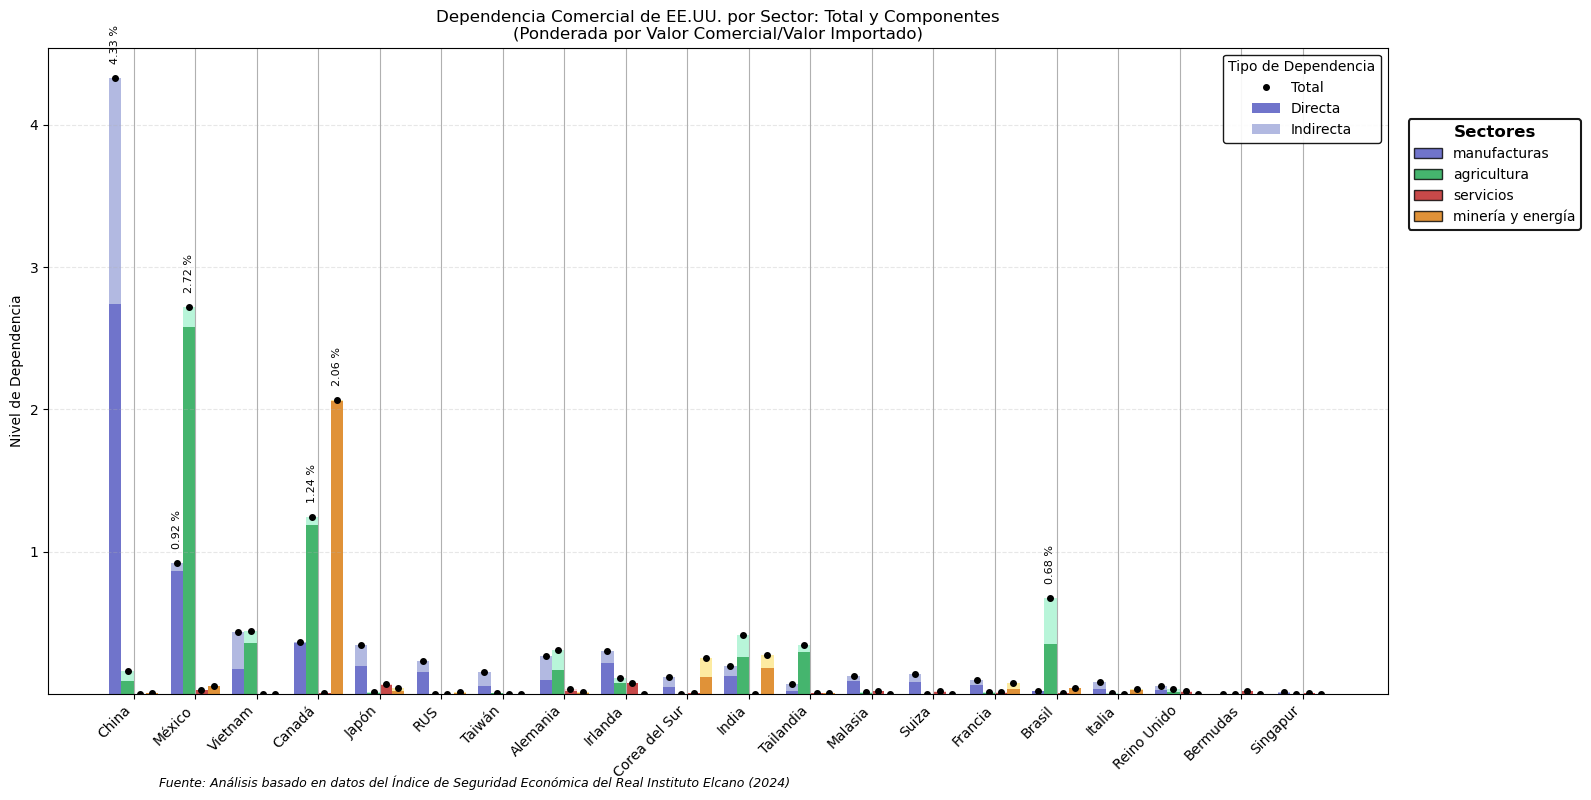

In [16]:

def analyze_us_dependencies(df_limpio, df_totales):
    """
    Analiza las dependencias comerciales de EE.UU. e incluye cálculos por sector.
    
    Args:
        df_limpio: DataFrame con datos de dependencias comerciales
        df_totales: DataFrame con datos de valor importado total
        
    Returns:
        DataFrame con las dependencias ponderadas ordenadas
    """
    # Filtrar datos para EE.UU. como país dependiente
    us_data = df_limpio[df_limpio['dependent_country'] == 'USA'].copy()
    print(f"Total de filas para EE.UU.: {len(us_data)}")
    
    # Unir con los datos de valor importado
    us_data = pd.merge(
        us_data,  # El primer DataFrame (que prevalece)
        df_totales[['industry', 'dependent_country', 'valor_importado']],  # Solo las columnas que necesitamos
        on=['industry', 'dependent_country'],  # Columnas para unir
        how='left'  # Mantener todas las filas del DataFrame izquierdo (primero)
    )
    
    # 1. Calcular el valor comercial total por país proveedor
    print("Calculando valor comercial por país...")
    trade_value_by_country = us_data.groupby('supplier_country')['trade_value'].sum().reset_index()
    trade_value_by_country = trade_value_by_country.sort_values('trade_value', ascending=False)
    
    # Obtener los 20 principales países por valor comercial
    top20_countries = trade_value_by_country.head(20)['supplier_country'].tolist()
    print(f"Top 20 países por valor comercial: {', '.join(top20_countries[:5])}...")
    
    # 2. Calcular dependencia media ponderada para cada uno de los top 20 países
    print("Calculando dependencias ponderadas...")
    dependency_results = []
    
    # 3. Añadir datos por sector para cada país
    # Definir mapeo de industrias a sectores (ejemplo)
    industry_to_sector = us_data['sectores'].unique()
    
    for country in top20_countries:
        # Filtrar datos para este país proveedor
        country_data = us_data[us_data['supplier_country'] == country].copy()
        
        # Calcular dependencia general para el país
        # Filtrar filas con valores válidos
        valid_rows = country_data.dropna(subset=['dependency_value', 'valor_importado'])
        valid_rows = valid_rows[valid_rows['valor_importado'] > 0]
        
        if len(valid_rows) == 0:
            dependency_results.append({
                'country': country,
                'weighted_dependency': 0,
                'weighted_direct_dependency': 0,
                'weighted_indirect_dependency': 0,
                'total_trade_value': trade_value_by_country[trade_value_by_country['supplier_country'] == country]['trade_value'].values[0]
            })
            continue
        
        total_importado = valid_rows['valor_importado'].sum()    

        # Calcular pesos basados en trade_value/valor_importado
        valid_rows['peso'] = valid_rows['trade_value'] / total_importado
        valid_rows['peso'] = valid_rows['peso'].fillna(0)  # Manejar casos donde valor_importado es 0
        
        # Calcular dependencia ponderada
        weighted_dependency = (valid_rows['dependency_value'] * valid_rows['peso']).sum()
        weighted_direct = (valid_rows['direct_dependency'] * valid_rows['peso']).sum()
        weighted_indirect = (valid_rows['indirect_dependency'] * valid_rows['peso']).sum()
        
        # Resultados por sector
        sector_results = {}
        for sector in industry_to_sector:
            sector_rows = valid_rows[valid_rows['sectores'] == sector]
            
            if len(sector_rows) == 0:
                sector_results[sector] = {
                    'weighted_dependency': 0,
                    'weighted_direct_dependency': 0,
                    'weighted_indirect_dependency': 0
                }
                continue
                
                
            total_importado = sector_rows['valor_importado'].sum()    

            # Calcular pesos basados en trade_value/valor_importado
            sector_rows = sector_rows.copy()
            sector_rows['peso'] = sector_rows['trade_value'] / total_importado
            sector_rows['peso'] = sector_rows['peso'].fillna(0)  # Manejar casos donde valor_importado es 0

            if total_importado > 0:                
                # Calcular dependencias ponderadas por sector
                sector_weighted_dependency = (sector_rows['dependency_value'] * sector_rows['peso']).sum()
                sector_weighted_direct = (sector_rows['direct_dependency'] * sector_rows['peso']).sum()
                sector_weighted_indirect = (sector_rows['indirect_dependency'] * sector_rows['peso']).sum()
            else:
                sector_weighted_dependency = 0
                sector_weighted_direct = 0
                sector_weighted_indirect = 0
                
            sector_results[sector] = {
                'weighted_dependency': sector_weighted_dependency,
                'weighted_direct_dependency': sector_weighted_direct,
                'weighted_indirect_dependency': sector_weighted_indirect
            }
        
        # Resultados generales del país
        result = {
            'country': country,
            'weighted_dependency': weighted_dependency,
            'weighted_direct_dependency': weighted_direct,
            'weighted_indirect_dependency': weighted_indirect,
            'total_trade_value': trade_value_by_country[trade_value_by_country['supplier_country'] == country]['trade_value'].values[0]
        }
        
        # Añadir resultados por sector
        for sector in industry_to_sector:
            result[f'{sector}_weighted_dependency'] = sector_results[sector]['weighted_dependency']
            result[f'{sector}_weighted_direct'] = sector_results[sector]['weighted_direct_dependency']
            result[f'{sector}_weighted_indirect'] = sector_results[sector]['weighted_indirect_dependency']
        
        dependency_results.append(result)
    
    # Convertir a DataFrame y ordenar por dependencia ponderada
    dependency_df = pd.DataFrame(dependency_results)
    dependency_df = dependency_df.sort_values('weighted_dependency', ascending=False)
    
    return dependency_df

def plot_dependencies_by_sector(dependency_df):
    """
    Crea un gráfico de barras apiladas para visualizar las dependencias por sector.
    
    Args:
        dependency_df: DataFrame con las dependencias calculadas
    """
    # Definir sectores (usar los mismos que en el análisis)
    sectores = us_data['sectores'].unique()
    
    # Preparar datos para el gráfico
    countries = dependency_df['country'].tolist()
    
    # Crear diccionario para mapear códigos de país a nombres completos
    country_names = {
        "CHN": "China", "VNM": "Vietnam", "CHE": "Suiza", "MYS": "Malasia",
        "IRL": "Irlanda", "MEX": "México", "JPN": "Japón", "TWN": "Taiwán",
        "DEU": "Alemania", "THA": "Tailandia", "CAN": "Canadá", "IND": "India",
        "FRA": "Francia", "ITA": "Italia", "KOR": "Corea del Sur", "BRA": "Brasil",
        "NLD": "Países Bajos", "SGP": "Singapur", "GBR": "Reino Unido", "BMU": "Bermudas"
    }
    
    # Mapear códigos a nombres completos (si están en el diccionario)
    country_labels = [country_names.get(c, c) for c in countries]
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Configurar dimensiones
    num_countries = len(countries)
    num_sectors = len(sectores)
    group_width = 0.8  # Ancho total disponible para cada grupo de país
    bar_width = group_width / num_sectors  # Ancho de cada barra individual
    
    # Definir colores para los sectores
    colors = ['#4C51BF', '#16A34A', '#B91C1C', '#D97706']
    light_colors = ['#9FA8DA', '#A7F3D0', '#FECACA', '#FDE68A']
    
    # Crear diccionarios para mapear sectores a colores
    sector_to_color = {sector: colors[i % len(colors)] for i, sector in enumerate(sectores)}
    sector_to_light_color = {sector: light_colors[i % len(light_colors)] for i, sector in enumerate(sectores)}
    
    for i, country in enumerate(countries):
        country_row = dependency_df[dependency_df['country'] == country].iloc[0]
        
        for j, sector in enumerate(sectores):
            # Obtener valores de dependencia para este sector y país
            # Usamos los valores calculados durante el análisis
            direct_val = country_row.get(f'{sector}_weighted_direct', 0)*100
            indirect_val = country_row.get(f'{sector}_weighted_indirect', 0)*100
            total_val = direct_val + indirect_val
            
            # Posición x para esta barra específica
            x_pos = i + (j * bar_width) - (group_width / 2) + (bar_width / 2)
            
            # Crear barras apiladas para este sector y país
            p1 = ax.bar(x_pos, direct_val, bar_width,
                      label=f'Directa' if i == 0 and j == 0 else "",
                      color=sector_to_color[sector], alpha=0.8)
            
            # Barras de dependencia indirecta (apiladas)
            p2 = ax.bar(x_pos, indirect_val, bar_width,
                      bottom=direct_val,
                      label=f'Indirecta' if i == 0 and j == 0 else "",
                      color=sector_to_light_color[sector], alpha=0.8)
            
            # Añadir marcador para dependencia total
            ax.plot(x_pos, total_val, 'ko', markersize=4,
                  label=f'Total' if i == 0 and j == 0 else "")
            
            # Añadir valor encima de la barra
            if total_val > 0.5:  # Solo mostrar valores significativos
                ax.text(x_pos, total_val + 0.1, f'{total_val:.2f} %', 
                      ha='center', va='bottom', fontsize=8, rotation=90)
    
    # Configurar ejes y leyendas
    ax.set_xticks(np.arange(len(countries)))
    ax.set_xticklabels(country_labels, rotation=45, ha='right')
    ax.set_ylabel('Nivel de Dependencia')
    ax.set_title('Dependencia Comercial de EE.UU. por Sector: Total y Componentes\n(Ponderada por Valor Comercial/Valor Importado)')
    
    # Crear leyenda para los tipos de dependencia (primera leyenda)
    handles, labels = ax.get_legend_handles_labels()
    first_legend = ax.legend(handles[:3], labels[:3], loc='upper right', 
                            title="Tipo de Dependencia", frameon=True, 
                            framealpha=0.9, edgecolor='black')
    
    ax.add_artist(first_legend)  # Mantener la primera leyenda
    
    # Crear leyenda separada para los sectores (segunda leyenda)
    sector_handles = []
    
    for sector in sectores:
        # Crear un rectángulo más grande para cada sector
        sector_handle = plt.Rectangle((0, 0), 1, 1, fc=sector_to_color[sector], alpha=0.8, 
                                    ec='black', linewidth=1)
        sector_handles.append(sector_handle)
    
    # Colocar la leyenda de sectores en un lugar más visible
    second_legend = ax.legend(sector_handles, sectores, 
                            loc='upper left', bbox_to_anchor=(1.01, 0.9),
                            title="Sectores", frameon=True, framealpha=0.9,
                            edgecolor='black', title_fontsize=12, fontsize=10)
    
    # Mejorar la apariencia de la leyenda de sectores
    second_legend.get_frame().set_linewidth(1.5)
    plt.setp(second_legend.get_title(), fontweight='bold')
    
    # Añadir grid para facilitar lectura
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Ajustar diseño para evitar recortes
    plt.tight_layout()
    
    # Añadir anotación con fuente
    plt.figtext(0.3, 0.01, "Fuente: Análisis basado en datos del Índice de Seguridad Económica del Real Instituto Elcano (2024)",
               ha="center", fontsize=9, style='italic')
    
    # Guardar y mostrar
    try:
        current_dir = Path.cwd()
        image_dir = current_dir / 'images'
        image_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(image_dir / 'us_dependencies_by_sector.png', dpi=300, bbox_inches='tight')
        print("Gráfico guardado como 'us_dependencies_by_sector.png'")
    except Exception as e:
        print(f"No se pudo guardar la imagen: {e}")
    
    plt.show()
    
    return

def main(df_limpio, df_totales):
    """Función principal para el análisis de dependencias."""
    # Realizar análisis
    dependency_df = analyze_us_dependencies(df_limpio, df_totales)
    
    # Mostrar resultados
    print("\nTop 20 países por dependencia ponderada:")
    for i, row in dependency_df.iterrows():
        print(f"{i+1}. {row['country']}: Dependencia: {row['weighted_dependency']:.3f}, " +
              f"Directa: {row['weighted_direct_dependency']:.3f} " +
              f"({row['weighted_direct_dependency']/row['weighted_dependency']*100:.1f}%), " +
              f"Indirecta: {row['weighted_indirect_dependency']:.3f} " +
              f"({row['weighted_indirect_dependency']/row['weighted_dependency']*100:.1f}%), " +
              f"Valor comercial: {row['total_trade_value']/1000:.0f}K USD")
    
    # Crear visualización
    plot_dependencies_by_sector(dependency_df)
    
    return dependency_df

# Ejemplo de uso (comentado para evitar ejecución accidental)


# Ejecutar análisis
dependency_df = main(df_limpio, df_totales)


Total de filas para relaciones EE.UU.-China: 139

Top sectores por dependencia de China:
390315. Games and toys: Dependencia: 0.984, Directa: 0.868 (88.2%), Indirecta: 0.116 (11.8%), Valor comercial: 17.8K USD
120008. Bicycles and invalid carriages: Dependencia: 0.865, Directa: 0.473 (54.7%), Indirecta: 0.392 (45.3%), Valor comercial: 1.2K USD
1013549. Raw and refined sugar and sugar crops: Dependencia: 0.862, Directa: 0.862 (100.0%), Indirecta: 0.000 (0.0%), Valor comercial: 0.0K USD
609390. Office accounting and computing machinery: Dependencia: 0.823, Directa: 0.471 (57.2%), Indirecta: 0.353 (42.8%), Valor comercial: 54.1K USD
524459. Made-up textile articles except apparel: Dependencia: 0.785, Directa: 0.569 (72.4%), Indirecta: 0.216 (27.6%), Valor comercial: 12.0K USD
1140554. TV and radio receivers and associated goods: Dependencia: 0.782, Directa: 0.470 (60.2%), Indirecta: 0.311 (39.8%), Valor comercial: 20.5K USD
1149100. TV/radio transmitters; line comm. apparatus: Dependencia

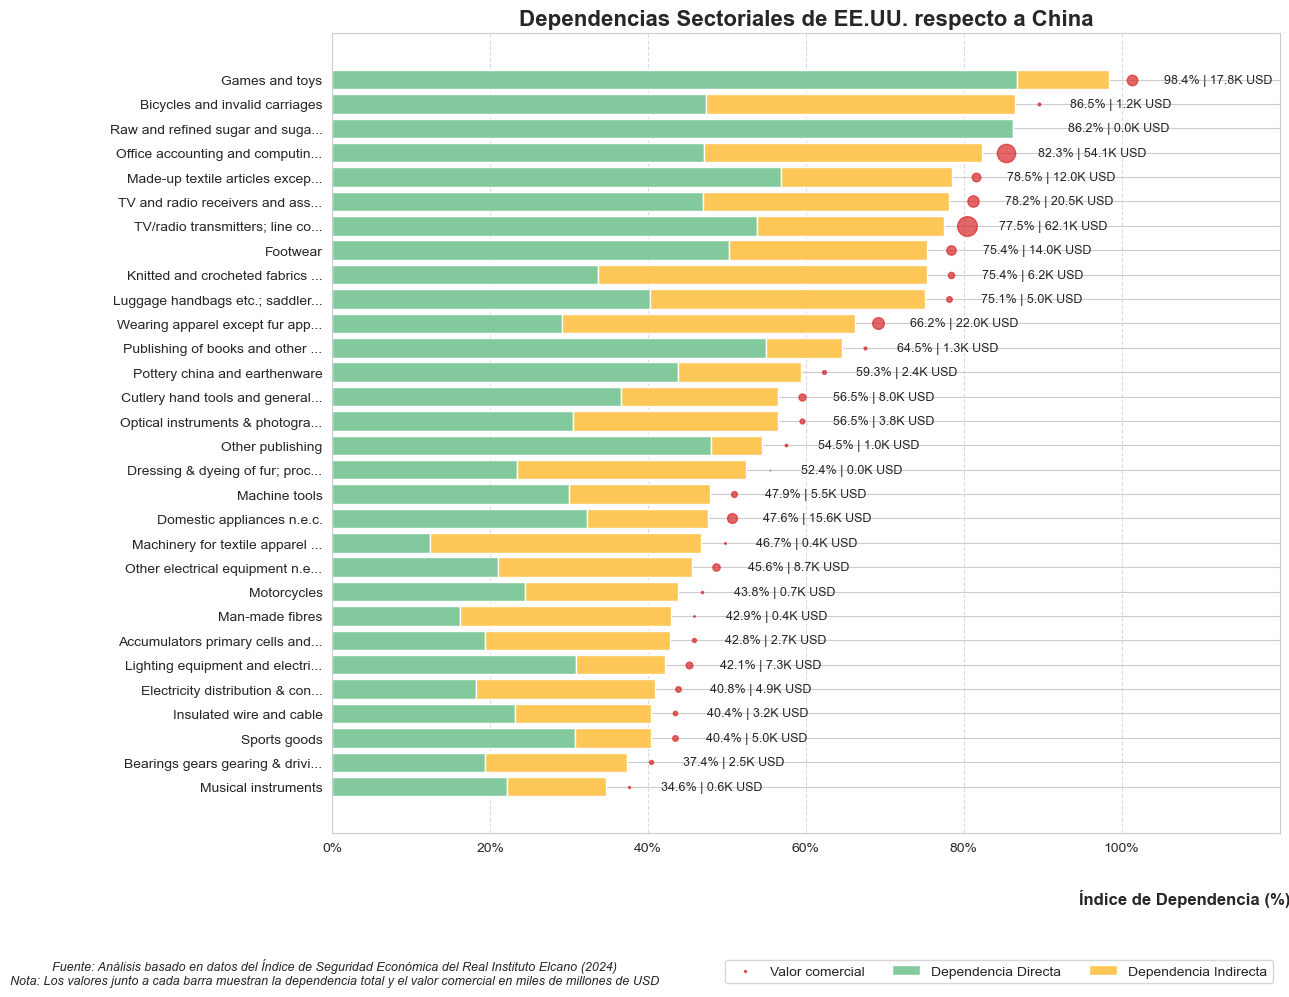

In [17]:
def analyze_china_sectoral_dependencies(num_sectors=30):
    """
    Analiza las dependencias sectoriales de EE.UU. respecto a China.
    
    Args:
        file_path: Ruta al archivo CSV de dependencias comerciales
        num_sectors: Número de sectores a mostrar en el gráfico
        
    Returns:
        DataFrame con los sectores de mayor dependencia
    """
    # Cargar los datos
    df = df_limpio.copy()
    
    # Filtrar datos para EE.UU. como país dependiente y China como proveedor
    us_china_data = df[(df['dependent_country'] == 'USA') & 
                        (df['supplier_country'] == 'CHN')].copy()
    
    print(f"Total de filas para relaciones EE.UU.-China: {len(us_china_data)}")
    
    # Filtrar registros válidos y con valor comercial positivo
    valid_data = us_china_data.dropna(subset=['dependency_value', 'trade_value', 'direct_dependency', 'indirect_dependency'])
    valid_data = valid_data[valid_data['trade_value'] > 0]
    
    # Ordenar por dependencia total
    sorted_data = valid_data.sort_values('dependency_value', ascending=False)
    
    # Obtener los N sectores con mayor dependencia
    top_sectors = sorted_data.head(num_sectors).copy()
    
    # Abreviar nombres de industrias demasiado largos
    top_sectors['short_industry'] = top_sectors['industry'].apply(
        lambda x: x[:30] + '...' if len(x) > 30 else x
    )
    
    # Crear columna con el porcentaje directo e indirecto
    total_dep = top_sectors['dependency_value']
    top_sectors['direct_pct'] = top_sectors['direct_dependency'] / total_dep * 100
    top_sectors['indirect_pct'] = top_sectors['indirect_dependency'] / total_dep * 100
    
    return top_sectors

def plot_china_sectoral_dependencies(sectors_df):
    """
    Crea un gráfico de barras horizontales para visualizar las dependencias sectoriales.
    
    Args:
        sectors_df: DataFrame con los sectores de mayor dependencia
    """
    # Preparar datos para el gráfico
    industries = sectors_df['short_industry'].tolist()
    direct_deps = sectors_df['direct_dependency'].tolist()
    indirect_deps = sectors_df['indirect_dependency'].tolist()
    trade_values = sectors_df['trade_value'].tolist()
    total_deps = sectors_df['dependency_value'].tolist()
    
    # Ordenar desde el valor más alto al más bajo (para visualización)
    indices = np.argsort(total_deps)
    industries = [industries[i] for i in indices]
    direct_deps = [direct_deps[i] for i in indices]
    indirect_deps = [indirect_deps[i] for i in indices]
    trade_values = [trade_values[i] for i in indices]
    total_deps = [total_deps[i] for i in indices]
    
    # Configurar el gráfico
    plt.figure(figsize=(12, 10))
    
    # Establecer estilo
    sns.set_style('whitegrid')
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Crear gráfico de barras horizontales apiladas
    y_pos = np.arange(len(industries))
    
    # Barras apiladas
    p1 = plt.barh(y_pos, direct_deps, color='#82ca9d', label='Dependencia Directa')
    p2 = plt.barh(y_pos, indirect_deps, left=direct_deps, color='#ffc658', label='Dependencia Indirecta')
    
    # Añadir valor comercial como tamaño de puntos
    max_trade = max(trade_values)
    normalized_trade = [t/max_trade * 200 for t in trade_values]  # Normalizar para tamaño visual
    
    # Añadir puntos que representan el valor comercial
    for i, (dep, trade, norm_trade) in enumerate(zip(total_deps, trade_values, normalized_trade)):
        plt.scatter(dep + 0.03, i, s=norm_trade, color='#d62728', alpha=0.7, 
                   label='Valor comercial' if i == 0 else "")
    
    # Añadir etiquetas con el valor de dependencia y comercial
    for i, (dep, trade) in enumerate(zip(total_deps, trade_values)):
        plt.text(dep + 0.07, i, f"{dep:.1%} | {trade/1000:.1f}K USD", 
         va='center', ha='left', fontsize=9)
    
    # Configurar ejes y etiquetas
    plt.yticks(y_pos, industries)
    # Por esto:
    plt.xlabel('Índice de Dependencia (%)', fontsize=12, fontweight='bold')
    
    # Posicionar etiqueta del eje X
    ax = plt.gca()
    ax.xaxis.set_label_coords(0.9, -0.07)
    
    plt.title('Dependencias Sectoriales de EE.UU. respecto a China', fontsize=16, fontweight='bold')
    
    # Ajustar límites del eje X para dar espacio a las anotaciones
    plt.xlim(0, 1.2)
    ax = plt.gca()
    #Crear etiquetas personalizadas solo hasta 100%
    x_positions = np.arange(0, 1.1, 0.2)  # Posiciones: 0, 0.2, 0.4, 0.6, 0.8, 1.0
    x_labels = [f'{x:.0%}' for x in x_positions]  # Etiquetas: 0%, 20%, 40%, 60%, 80%, 100%
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels)

    # Añadir leyenda
    plt.legend(loc='upper right', bbox_to_anchor=(1, -0.15), ncol=3)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Añadir cuadrícula vertical
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Añadir anotación con fuente y explicación
    plt.figtext(0.2, 0.01, 
                "Fuente: Análisis basado en datos del Índice de Seguridad Económica del Real Instituto Elcano (2024)\n"
                "Nota: Los valores junto a cada barra muestran la dependencia total y el valor comercial en miles de millones de USD",
                ha="center", fontsize=9, style='italic')
    
    # Guardar y mostrar

    plt.savefig(image_dir / 'us_china_sectoral_dependencies.png', dpi=300, bbox_inches='tight')
    print("Gráfico guardado como 'us_china_sectoral_dependencies.png'")
    plt.show()
    
    return

def main():
    """Función principal para el análisis de dependencias sectoriales."""
    
    
    # Realizar análisis de los 15 sectores principales
    sectors_df = analyze_china_sectoral_dependencies(num_sectors=30)
    
    # Mostrar resultados
    print("\nTop sectores por dependencia de China:")
    for i, row in sectors_df.sort_values('dependency_value', ascending=False).iterrows():
        print(f"{i+1}. {row['industry']}: Dependencia: {row['dependency_value']:.3f}, " +
              f"Directa: {row['direct_dependency']:.3f} ({row['direct_pct']:.1f}%), " +
              f"Indirecta: {row['indirect_dependency']:.3f} ({row['indirect_pct']:.1f}%), " +
              f"Valor comercial: {row['trade_value']/1000:.1f}K USD")
    
    # Crear visualización
    plot_china_sectoral_dependencies(sectors_df)
    
    return sectors_df

if __name__ == "__main__":
    sectors_df = main()